In [1]:
import math
from typing import *
import numpy as np
import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_bloch_vector
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
sim = AerSimulator()

from util import zero, one, statevector_to_bloch_vector

# Shor's Part 2/5: The Quantum Fourier Transform

The **Quantum Fourier Transform** (QFT), by analogy with the classical Fourier Transform, represents a quantum state in the "frequency" domain. It is a fundamental building block in Shor's algorithm where the periodicities in data can be extracted to factor integers efficiently.

References
1. [Introduction to Classical and Quantum Computing, Chapter 7.7.3](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
3. [Introduction to Quantum Information Science: Lectures 19 and 20 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
4. [Quantum Computation and Quantum Information: Chapter 5, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Definition

The **Quantum Fourier Transform** (**QFT**) over $t$ qubits ($T = 2^t$) is defined as the $T \times T$ matrix $F_T$ whose $j$-th and $k$-th entry is

\begin{align*}
(F_T)_{j, k} & = \omega^{j k}_T
\end{align*}

where

$$
\omega_{T}^{jk} = e^{2\pi i \frac{jk}{T}}
$$

is a **root of unity**.

In [2]:
def root_of_unity(j: int, k: int, T: int) -> np.complex64:
    return np.exp(2 * np.pi * 1j * j * k / T)

def mk_F(T: int) -> Operator:
    return 1/np.sqrt(T) * Operator([[root_of_unity(j, k, T) for j in range(0, T)] for k in range(0, T)])

### Aside: Roots of unity

We can visualize a root of unity on the unit circle.

In [3]:
def plot_roots_of_unity(k: int, T: int) -> None:
    fig = plt.figure(figsize=(4, 4)); ax = fig.add_subplot()
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

    # Plot
    jks = [(j, k) for j in range(T)]
    txt = [f"exp(2$\\pi i\\cdot{j}\\cdot{k}/{T})$" for i, (j, k) in enumerate(jks)]
    zs = [np.exp(2*np.pi*j*k/T*1j) for j, k in jks]
    for i, t in enumerate(txt):
        plt.annotate(t, (zs[i].real, zs[i].imag))

    # Plot meta-data
    plt.plot([z.real for z in zs], [z.imag for z in zs], linestyle="none", marker='x')
    plt.axhline(y=0.0, color="r", linestyle="-"); plt.axvline(x=0.0, color="r", linestyle="-")
    plt.xlabel("Real"); plt.ylabel("Imaginary"); plt.title(r"$e^{2 \pi i \cdot j \cdot k/T}$");

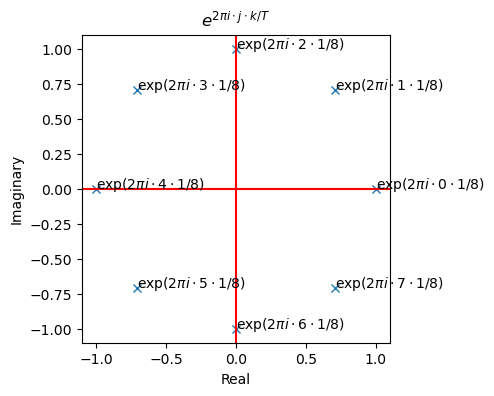

In [4]:
# k = 1, so it takes us 8 traverses to reach our starting point
plot_roots_of_unity(1, 8)

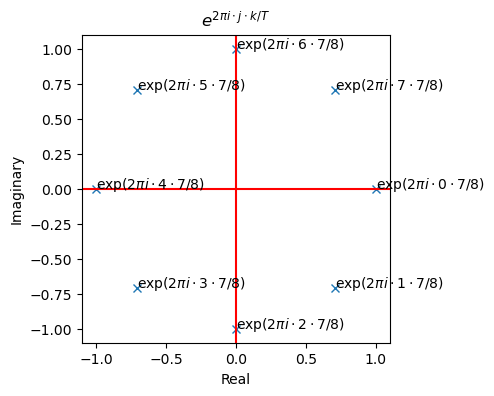

In [5]:
# k = 7, so it takes us 8 traverses to reach the starting point
plot_roots_of_unity(7, 8)

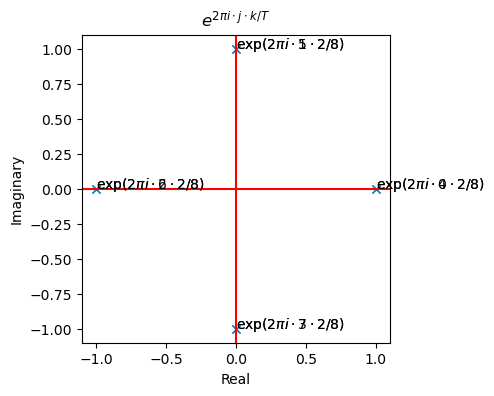

In [6]:
# k = 2, so it takes us 4 traverses to reach the starting point
plot_roots_of_unity(2, 8)

### Root of Unity Encodes Period Information

For any arbitrary starting point, the number of times needed to cycle back to that point encodes information about the period $T$. For instance,
- 8 traverses implies either $k = 1$ or $k = 7$ and $T = 8$.
- Similarly, 2 traverses implies either $k = 2$ and $T = 8$ or $k = 6$ and $T = 8$.

Thus a root of unity $\omega_T^{jk}$ encodes the number of times needed to reach the starting point, without needing to know the starting point!

## Examples

To unpack the formal definition of a QFT, we'll give a few examples now.

### Example: QFT on 1 Qubit

Unpacking the definition for $T = 2$, we obtain

\begin{align*}
F_2 & = \frac{1}{\sqrt{2}} \begin{pmatrix}
\omega_2^{0 \cdot 0} & \omega_2^{1 \cdot 0} \\
\omega_2^{0 \cdot 1} & \omega_2^{1 \cdot 1}
\end{pmatrix} \\
& = \frac{1}{\sqrt{2}} \begin{pmatrix}
1 & 1 \\
1 & -1 \\
\end{pmatrix} \,.
\end{align*}

This is a Hadamard gate!

In [7]:
F_2 = mk_F(2)
F_2.draw("latex")

<IPython.core.display.Latex object>

#### $F_2$ on basis

We can visualize the effect of $F_2$ on the computational basis. In particular, it maps the computational basis into the $|+\rangle$ and $|-\rangle$ basis.

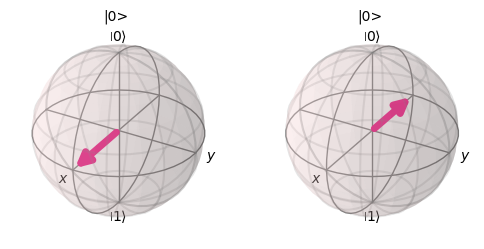

In [8]:
fig = plt.figure(figsize = [6, 9])
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

# Using global phase
plot_bloch_vector(statevector_to_bloch_vector(zero.evolve(F_2)), ax=ax1, title="|0>")
plot_bloch_vector(statevector_to_bloch_vector(one.evolve(F_2)), ax=ax2, title="|0>")

### Example: QFT on 2 Qubits

\begin{align*}
F_4 & = \frac{1}{2}\begin{pmatrix}
\omega_2^{0 \cdot 0} & \omega_2^{1 \cdot 0} & \omega_2^{2 \cdot 0} & \omega_2^{3 \cdot 0} \\
\omega_2^{0 \cdot 1} & \omega_2^{1 \cdot 1} & \omega_2^{2 \cdot 1} & \omega_2^{3 \cdot 1} \\
\omega_2^{0 \cdot 2} & \omega_2^{1 \cdot 2} & \omega_2^{2 \cdot 2} & \omega_2^{3 \cdot 2} \\
\omega_2^{0 \cdot 3} & \omega_2^{1 \cdot 3} & \omega_2^{2 \cdot 3} & \omega_2^{3 \cdot 3}
\end{pmatrix}
\end{align*}

In [9]:
F_4 = mk_F(4)
F_4.draw("latex")

<IPython.core.display.Latex object>

#### $F_4$ on basis

$F_4$ performs a similar style of transform on the computational basis to $F_2$. In particular, it maps the computational basis into superpositions of the computational basis.

In [10]:
(zero^zero).evolve(F_4).draw("latex")

<IPython.core.display.Latex object>

In [11]:
(zero^one).evolve(F_4).draw("latex")

<IPython.core.display.Latex object>

In [12]:
(one^zero).evolve(F_4).draw("latex")

<IPython.core.display.Latex object>

In [13]:
(one^one).evolve(F_4).draw("latex")

<IPython.core.display.Latex object>

#### Example: QFT on 3 Qubits

The QFT for 3 qubits is a $8 \times 8$ matrix.

In [14]:
mk_F(8).draw("latex")

<IPython.core.display.Latex object>

## QFT Encodes Information in Phase

The QFT transform the computational basis into another basis that encodes information in the **global phase**. To see this, we can rewrite the $F_T$ with the following formula

$$
F_{T} = \frac{1}{\sqrt{T}} \sum_{j=0}^{T-1} \sum_{k=0}^{T-1} \omega_{T}^{jk}|\overline{k}\rangle \langle \overline{j}|
$$

where $|\overline{j}\rangle$ is the binary encoding in $t$ bits of the number $j$. 

Using this alternative characterization of the QFT, we can see that it maps each element in the computational basis into a superposition of computational basis elements offset by a global phase as in

\begin{align*}
F_T |\overline{l}\rangle & = (\frac{1}{\sqrt{T}} \sum_{j=0}^{T-1} \sum_{k=0}^{T-1} \omega_T^{jk}|\overline{k}\rangle \langle \overline{j}|) |\overline{l}\rangle \tag{definition} \\
& = \frac{1}{\sqrt{T}} \sum_{j=0}^{T-1} \sum_{k=0}^{T-1} \omega_T^{jk}|\overline{k}\rangle \langle \overline{j}| |\overline{l}\rangle) \tag{linearity} \\
& = \frac{1}{\sqrt{T}} \sum_{k=0}^{T-1} \omega_T^{lk}|\overline{k}\rangle \tag{orthogonality} \,.
\end{align*}

Thus the QFT enables the storage of information in the global phase. To foreshadow what's to come, **quantum phase estimation**, will be a procedure used to read out information stored in the phase.

## Binary Representation of QFT

Define the notation

\begin{align*}
0.j_{t-1} \dots j_0 & = \frac{1}{2^t} (j_{t-1} \dots j_0) \\
& = \frac{j_{t-1}}{2} + \dots + \frac{j_0}{2^{t}} \,.
\end{align*}

Then we can alternatively write the QFT $F_T$ as

$$
F_T |j_1 \dots j_t\rangle = \frac{(|0\rangle + e^{2\pi i 0.j_0}|1\rangle)(|0\rangle + e^{2\pi i 0.j_1 j_0}|1\rangle)\dots(|0\rangle + e^{2\pi i 0.j_{t-1} \dots j_0}|1\rangle)}{2^{t/2}} \,.
$$

### Example: F_2

\begin{align*}
F_2 |j_1\rangle & = \frac{(|0\rangle + e^{2\pi i 0.j_0}|1\rangle)}{2^{1/2}} \\
& = \frac{(|0\rangle + e^{2\pi i j_0/2}|1\rangle)}{\sqrt{2}} \\
\end{align*}

Thus

$$
F_2 |0\rangle = \frac{(|0\rangle + |1\rangle)}{\sqrt{2}}
$$

and

$$
F_2 |1\rangle = \frac{(|0\rangle - |1\rangle)}{\sqrt{2}} \,.
$$

### Example: F_4

\begin{align*}
F_T |j_1 j_2\rangle & = \frac{(|0\rangle + e^{2\pi i 0.j_0}|1\rangle)(|0\rangle + e^{2\pi i 0.j_1j_0}|1\rangle)}{2^{2/2}} \\
& = \frac{(|0\rangle + e^{2\pi i j_0/2}|1\rangle)(|0\rangle + e^{2\pi i (j_1/2 + j_0/4)}|1\rangle)}{2} \\
& = \frac{|00\rangle + e^{2\pi i (j_1/2 + j_0/4)}|01\rangle + e^{2\pi i j_0/2}|10\rangle + e^{2\pi i (j_1/2 + 3j_0/4)|11\rangle}}{2} \\
\end{align*}

Thus
1. 

$$
F_T |00\rangle = \frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{2} \,
$$

2. 

$$
F_T |01\rangle =  \frac{|00\rangle + i|01\rangle - |10\rangle + i|11\rangle}{2} \,
$$

3. 

$$
F_T |10\rangle =  \frac{|00\rangle - |01\rangle + |10\rangle - |11\rangle}{2} \,
$$

and

4. 

$$
F_T |11\rangle =  \frac{|00\rangle - |01\rangle - |10\rangle + |11\rangle}{2} \,.
$$

## QFT Circuit

It isn't obvious that we can construct a circuit that implements the QFT with a polynomial number of gates. Thankfull, we can rely on a recurrence relation to make it possible to construct a QFT in $O(t^2)$ gates.

### Observation 1

Applying H to first qubit produces

\begin{align*}
(I^{t-1} \otimes H) |j_{t-1} \dots j_0\rangle & = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i 0.j_0}|1\rangle) |j_{t-1} \dots j_1\rangle \,.
\end{align*}

### Observation 2

1. Let

$$
R_k = \begin{pmatrix}
1 & 0 \\
0 & e^{2\pi i / 2^k}
\end{pmatrix} \,.
$$
be a rotation gate.

2. Let $CR_k^t$ be a controlled rotation gate that applies $R_k$ to qubit $t$ if qubit $k$ is set.

Then applying $CR_{t}^0 \dots CR_{2}^0$ to the first qubit produces

\begin{align*}
CR_{t}^0 \dots CR_{2}^0 |\psi_1\rangle & = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i 0.j_{t-1}\dots j_1}|1\rangle) |j_{t-1} \dots j_1\rangle \\
\end{align*}

### Observation 3

Observe that

$$
F_T |j_{t-1} \dots j_0\rangle = CR_{t}^0 \dots CR_{2}^0 (F_{T/2}|j_{t-1} \dots j_{0}\rangle \otimes H|j_0\rangle) \,.
$$

This recurrence relation can be used to efficiently construct a QFT.

### Example: QFT on 2 qubits

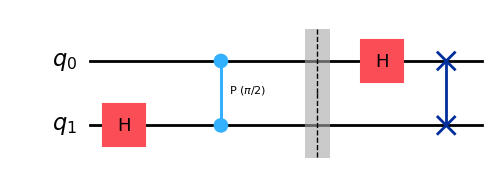

In [15]:
qft2 = QuantumCircuit(2)
qft2.h(1)
qft2.cp(np.pi/2, 0, 1)
qft2.barrier()
qft2.h(0)
qft2.swap(0, 1) # little endian ...
qft2.draw(output="mpl", style="iqp")

In [16]:
np.allclose(Operator(qft2), F_4)

True

### Example: QFT on 3 qubits

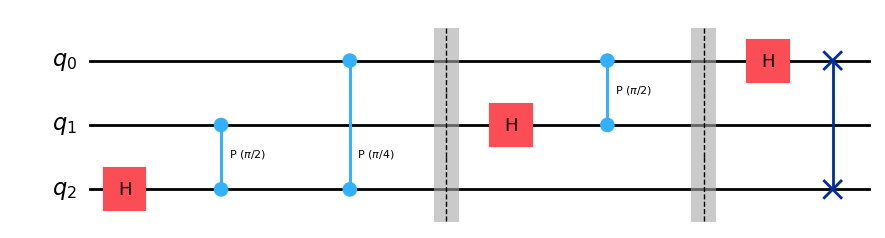

In [17]:
qft3 = QuantumCircuit(3)
qft3.h(2)
qft3.cp(np.pi/2, 2, 1) 
qft3.cp(np.pi/4, 2, 0)
qft3.barrier()
qft3.h(1)
qft3.cp(np.pi/2, 1, 0)
qft3.barrier()
qft3.h(0)
qft3.swap(0, 2) # little endian ...
qft3.draw(output="mpl", style="iqp")

In [18]:
np.allclose(Operator(qft3), mk_F(8))

True

#### Arbitrary qubits

1. You can use the recurrence relation to write the circuit for arbitrary quibits.
2. See [https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)

In [19]:
def qft(circuit, n):
    def go(circuit, n):
        if n == 0:
            return circuit
        else:
            n -= 1
            # Apply H
            circuit.h(n)
            # Apply CR
            for qubit in range(n):
                circuit.cp(np.pi/2**(n-qubit), qubit, n)
            # Recurrence relation
            return go(circuit, n)
    circuit = go(circuit, n) 

    # Take care of little endian
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

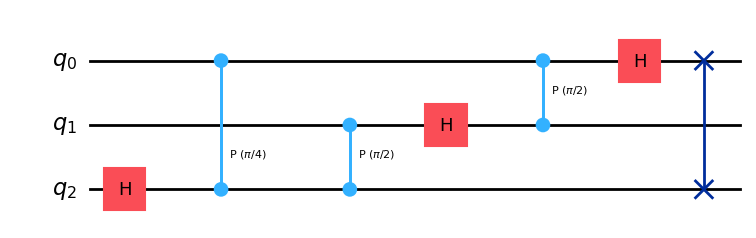

In [20]:
qft3_ = QuantumCircuit(3)
qft3_ = qft(qft3_, 3)
qft3_.draw(output="mpl", style="iqp")

In [21]:
np.allclose(Operator(qft3), Operator(qft3_))

True

#### How many gates?

Note that

$$
t + (t - 1) + \dots 1 = \frac{t(t - 1)}{2} \,.
$$ 

Thus we require $O(t^2)$ gates.

## Summary

1. The QFT performs a change-of-basis that enables us to store information in the global phase.
2. Later, we will use the **quantum phase estimation** (QPE) algorithm to read this information out.